# Training models

## Imports

In [1]:
from data_preprocessing import (
    full_pipeline,
    splits_to_dataloaders,
    split_classif_reg_targets,
)
from random_forest import run_experiment as run_random_forest_experiment
from random_forest import benchmark_random_forest
from two_stage_rf import run_experiment as run_two_stage_rf_experiment
from xg_boost import run_experiment as run_xgboost_experiment
from xg_boost import benchmark_xgboost
from nn import run_experiment as run_nn_experiment
from nn import evaluate_nn_regressor, RegressorV3, submit_nn
from linreg import run_experiment as run_linreg_experiment
from utils import write_submissions, evaluate_model, stratify_by_humidity
from residual_attention_net import RAMTNet
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

## Load and prepare data

In [2]:
data_dir = "./data/"
train_x_path = os.path.join(data_dir, "x_train_T9QMMVq.csv")
train_y_path = os.path.join(data_dir, "y_train_R0MqWmu.csv")
test_x_path = os.path.join(data_dir, "x_test_9F13O5s.csv")

params_pipeline_feateng = {
    "split_humidity": True,
    "h_threshold": 0.211,
    "split": False,
    "val_proportion": 0.5,
    "rescale": False,
    "reduce_features": False,
    "augment": False,
    "apply_feat_eng": True,
    "polynomial_degree": 2,
    "include_group_interactions": True,
    "include_humidity_interactions": True,
    "feature_selection": False,
    "k_features": 30,
    "remove_outliers": False,
    "k": 10.0,
    "binarize_humidity": False,
    "n_bins": 5,
    "remove_humidity": False,
}

params_pipeline = {
    "split_humidity": True,
    "h_threshold": 0.211,
    "split": False,
    "val_proportion": 0.5,
    "rescale": False,
    "reduce_features": False,
    "augment": False,
    "apply_feat_eng": False,
    "polynomial_degree": 2,
    "include_group_interactions": True,
    "include_humidity_interactions": True,
    "feature_selection": False,
    "k_features": 30,
    "remove_outliers": False,
    "k": 10.0,
    "binarize_humidity": False,
    "n_bins": 5,
    "remove_humidity": False,
}

x_train, y_train, x_val, y_val = full_pipeline(
    train_x_path, train_y_path, **params_pipeline
)
x_test = full_pipeline(test_x_path, None, **params_pipeline)

# Create stratified validation sets
# x_val_strata, y_val_strata, labels = stratify_by_humidity(x_val, y_val, n_strata=5)

print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)
print("X val shape:", x_val.shape)
print("Y val shape:", y_val.shape)
print("---")
print("X test shape:", x_test.shape)
print("---")

X train shape: (176676, 14)
Y train shape: (176676, 23)
X val shape: (26257, 14)
Y val shape: (26257, 23)
---
X test shape: (134673, 14)
---


## Standard Regressors

### Random Forest Regressor

In [8]:
print("Basic Random Forest")
rf_model = run_random_forest_experiment(x_train, y_train, x_val, y_val)

Basic Random Forest
Training Weighted RMSE: 0.1183
Validation Weighted RMSE: 0.1416


In [ ]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [7, 10, 15, None],
    "min_samples_split": [0.005, 0.01, 0.02],
    "min_samples_leaf": [20, 30, 50],
}
benchmark = False
if benchmark:
    try:
        best_model_rf, best_params_rf, best_val_rmse_rf = benchmark_random_forest(
            x_train,
            y_train,
            x_val,
            y_val,
            param_grid=param_grid,
            verbose=False,
            subset_humidity=False,
        )
    except KeyboardInterrupt:
        print("KeyboardInterrupt: Stopping the benchmarking process.")

In [12]:
best_params = {
    "n_estimators": 100,
    "max_depth": None,
    "min_samples_split": 0.005,
    "min_samples_leaf": 20,
    "random_state": 29,
    "n_jobs": -1,
}

best_rf_model = run_random_forest_experiment(
    x_train, y_train, x_val, y_val, params=best_params
)

Training Weighted RMSE: 0.0703
Validation Weighted RMSE: 0.0929


### XGBoost

In [ ]:
params = {
    "n_estimators": 50,
    "max_depth": 6,
    "learning_rate": 0.05,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "min_child_weight": 10,
    "gamma": 0,
    "reg_alpha": 0,
    "reg_lambda": 1,
    "random_state": 29,
    "n_jobs": -1,
}
xgb = run_xgboost_experiment(x_train, y_train, x_val, y_val, params=params)

### Multi Linear Regression with feature selection

In [3]:
feat_eng = False
if feat_eng:
    x_train, y_train, x_val, y_val = full_pipeline(
        train_x_path, train_y_path, **params_pipeline_feateng
    )
    x_test = full_pipeline(test_x_path, None, **params_pipeline_feateng)
print("Train shape:", x_train.shape)
print("Val shape:", x_val.shape)
assert x_train.shape[1] == x_test.shape[1], (
    f"x_train and x_test have different number of features: "
    f"{x_train.shape[1]} != {x_test.shape[1]}."
    f"'ID' in train: {('ID' in x_train.columns)},"
    f"'ID' in test: {('ID' in x_test.columns)}."
)
try:
    linear_model = run_linreg_experiment(x_train, y_train, x_val, y_val, alpha=0.05)
except KeyboardInterrupt:
    print("KeyboardInterrupt received. Stopping training.")

Train shape: (176676, 14)
Val shape: (26257, 14)
Training SelectiveLinearRegressor model...


 61%|██████    | 14/23 [00:01<00:01,  8.02it/s]/Users/kiki/.pyenv/versions/3.12.2/envs/idgaz/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
100%|██████████| 23/23 [00:02<00:00,  7.96it/s]


Feature selection results:
c01: 12 features selected - R^2 before selection: 0.5632865292638675 - R^2 after selection: 0.5632782350846592
c02: 13 features selected - R^2 before selection: 0.09420782504771652 - R^2 after selection: 0.09420782504771652
c03: 13 features selected - R^2 before selection: 0.4237128087042875 - R^2 after selection: 0.42371280870428774
c04: 13 features selected - R^2 before selection: 0.4237128087042875 - R^2 after selection: 0.42371280870428774
c05: 12 features selected - R^2 before selection: 0.2109982538125904 - R^2 after selection: 0.21099555954064142
c06: 12 features selected - R^2 before selection: 0.2109982538125904 - R^2 after selection: 0.21099555954064142
c07: 13 features selected - R^2 before selection: 0.09420782504771652 - R^2 after selection: 0.09420782504771652
c08: 10 features selected - R^2 before selection: 0.03892509415785239 - R^2 after selection: 0.03886561926699361
c09: 11 features selected - R^2 before selection: 0.1885818346242163 - R^2 

100%|██████████| 23/23 [00:00<00:00, 814.42it/s]

Training Weighted RMSE: 0.1772
Validation Weighted RMSE: 0.1865


In [8]:
evaluate_model(linear_model, x_val, y_val)

100%|██████████| 23/23 [00:00<00:00, 53.57it/s]


0.13396921310406534

In [9]:
write_submissions(
    linear_model,
    test_x_path,
    "submissions_multi_regression_feateng.csv",
    use_embed=False,
    **params_pipeline_feateng,
)

Using 181 features


100%|██████████| 23/23 [00:03<00:00,  6.03it/s]


## Deep Learning

### Rescale data

In [21]:
params_pipeline_dl = {
    "split_humidity": True,
    "h_threshold": 0.211,
    "split": False,
    "val_proportion": 0.5,
    "rescale": True,
    "reduce_features": False,
    "augment": False,
    "apply_feat_eng": False,
    "polynomial_degree": 1,
    "include_group_interactions": False,
    "include_humidity_interactions": False,
    "feature_selection": False,
    "k_features": 30,
    "remove_outliers": False,
    "k": 10.0,
    "binarize_humidity": False,
    "n_bins": 5,
    "remove_humidity": False,
}

x_train, y_train, x_val, y_val = full_pipeline(
    train_x_path, train_y_path, **params_pipeline_dl
)
x_test = full_pipeline(test_x_path, None, **params_pipeline_dl)

### RAMTNet

In [22]:
params_ramt = {
    "model_class": "RAMTNet",
    "model_params": {
        "num_features": x_train.drop(columns=["ID"]).shape[1],
        "num_tasks": y_train.shape[1],
        "embed_dim": 16,
        "num_heads": 1,
        "shared_dim": 128,
        "num_res_blocks": 1,
        "dropout_rate": 0.3,
        "head_hidden": 64,
    },
    "training_params": {
        "n_epochs": 10,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 256,
        "patience": 2,
        "factor": 0.5,
        "min_lr": 1e-6,
        "loss": "WeightedRMSELoss",
    },
}

Number of trainable parameters: 228631


Epoch 10/10 - Train Loss: 0.0862, Val Loss: 0.2334, LR: 0.001250: 100%|██████████| 10/10 [05:27<00:00, 32.76s/it]


Final Validation Weighted RMSE: 0.2334


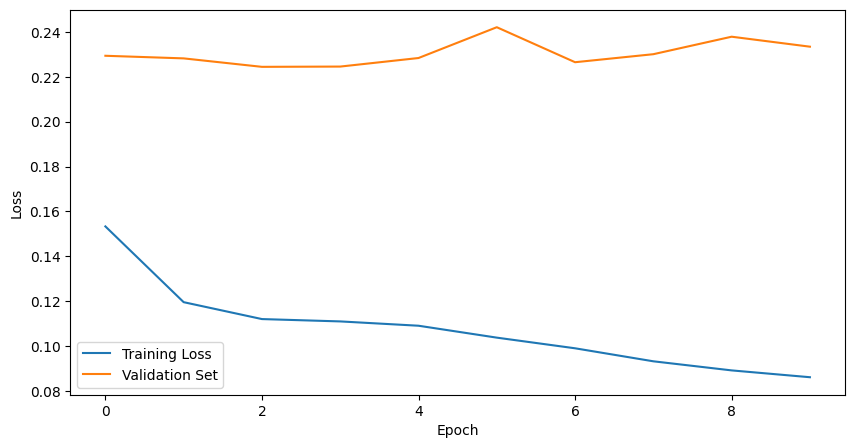

In [23]:
try:
    ramtnet = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        [(x_val, y_val)],
        params=params_ramt,
        uda=False,
        verbose=True,
        plot_losses=True,
        labels=None,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [24]:
error = evaluate_model(ramtnet, x_val, y_val)
print(f"Validation error: {error}")

Validation error: 0.23364904580516174


In [ ]:
torch.save(ramtnet.state_dict(), "ramtnet_base.pth")

### RegressorV3

Number of trainable parameters: 8047


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.1229, Val Loss: 0.2544, LR: 0.001250: 100%|██████████| 10/10 [01:13<00:00,  7.34s/it]


Final Validation Weighted RMSE: 0.2544


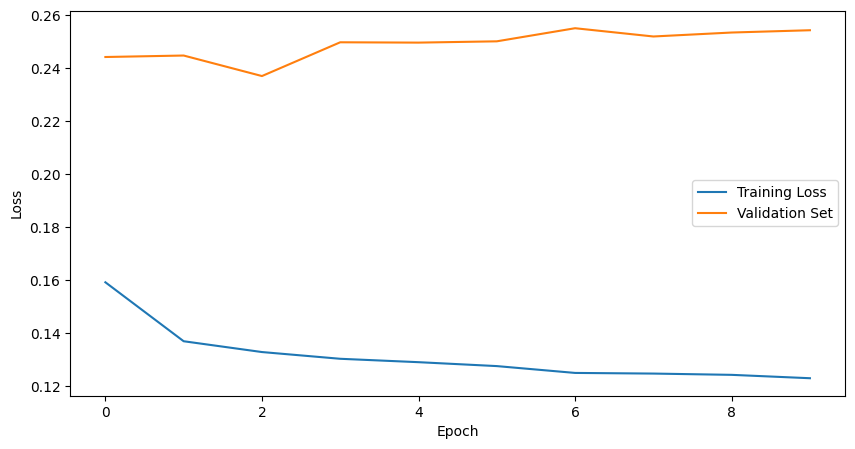

In [25]:
params_reg_v3 = {
    "model_class": "RegressorV3",
    "model_params": {
        "hidden_dim": 64,
        "num_output": 23,
        "humidity_dim": 8,
        "group_embed_dim": 16,
        "bias": True,
        "dropout_rate": 0.1,
    },
    "training_params": {
        "n_epochs": 10,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 256,
        "patience": 2,
        "factor": 0.5,
        "min_lr": 1e-6,
        "loss": "WeightedRMSELoss",
    },
}
try:
    reg_v3 = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        [(x_val, y_val)],
        uda=False,
        params=params_reg_v3,
        lambda_domain=0.25,
        verbose=True,
        plot_losses=True,
        labels=None,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [26]:
print(f"Weighted RMSE on validation set: {evaluate_model(reg_v3, x_val, y_val):.4f}")

Weighted RMSE on validation set: 0.2545


In [ ]:
torch.save(reg_v3.state_dict(), "reg_v3_base.pth")

### NNRegressor

Number of trainable parameters: 4247


Epoch 10/10 - Train Loss: 0.2171, Val Loss: 0.6806, LR: 0.002500: 100%|██████████| 10/10 [00:51<00:00,  5.12s/it]


Final Validation Weighted RMSE: 0.6806


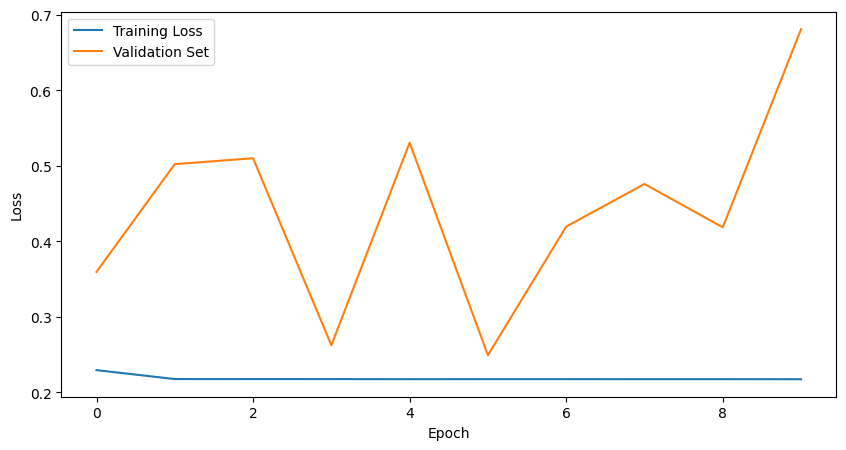

In [27]:
params_nnreg = {
    "model_class": "NNRegressor",
    "model_params": {
        "hidden_dim": 64,
        "num_output": 23,
        "bias": True,
        "dropout_rate": 0.1,
    },
    "training_params": {
        "n_epochs": 10,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 256,
        "patience": 2,
        "factor": 0.5,
        "min_lr": 1e-6,
        "loss": "WeightedRMSELoss",
    },
}

try:
    nnreg = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        [(x_val, y_val)],
        uda=False,
        params=params_nnreg,
        lambda_domain=0.25,
        verbose=True,
        plot_losses=True,
        labels=None,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [28]:
print(f"Weighted RMSE on validation set: {evaluate_model(nnreg, x_val, y_val):.4f}")

Weighted RMSE on validation set: 0.6807


In [ ]:
torch.save(nnreg.state_dict(), "nnreg_base.pth")

### GasDetectionModel

Number of trainable parameters: 8943


Epoch 10/10 - Train Loss: 0.0683, Val Loss: 0.2369, LR: 0.001250: 100%|██████████| 10/10 [01:11<00:00,  7.15s/it]


Final Validation Weighted RMSE: 0.2369


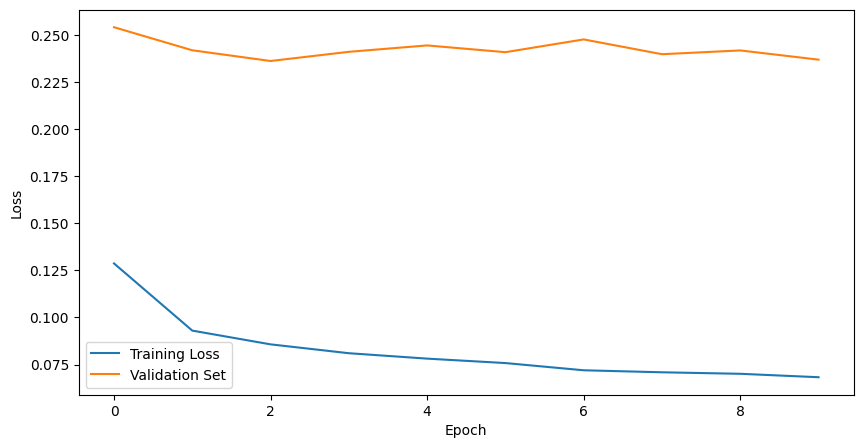

In [29]:
params_gasdet = {
    "model_class": "GasDetectionModel",
    "model_params": {
        "hidden_dim": 64,
        "num_output": 23,
        "dropout_rate": 0.1,
    },
    "training_params": {
        "n_epochs": 10,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 256,
        "patience": 2,
        "factor": 0.5,
        "min_lr": 1e-6,
        "loss": "WeightedRMSELoss",
    },
}

try:
    gasdet = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        [(x_val, y_val)],
        uda=False,
        params=params_gasdet,
        lambda_domain=0.25,
        verbose=True,
        plot_losses=True,
        labels=None,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [30]:
print(f"Weighted RMSE on validation set: {evaluate_model(gasdet, x_val, y_val):.4f}")

Weighted RMSE on validation set: 0.2371


In [ ]:
torch.save(gasdet.state_dict(), "gasdet_base.pth")

## Two-stage approach

In [3]:
y_train_classif, y_train_reg = split_classif_reg_targets(y_train)
y_val_classif, y_val_reg = split_classif_reg_targets(y_val)

In [4]:
clf_params = {
    "n_estimators": 50,
    "max_depth": None,
    "min_samples_split": 0.005,
    "min_samples_leaf": 20,
    "random_state": 29,
    "n_jobs": -1,
}

reg_params = { # simple xgboost
    "n_estimators": 10,
    "random_state": 29,
}

two_stage_rf = run_two_stage_rf_experiment(
    x_train,
    y_train,
    y_train_classif,
    y_train_reg,
    x_val,
    y_val,
    y_val_classif,
    y_val_reg,
    clf_params=clf_params,
    reg_params=reg_params,
)

: 

Number of trainable parameters: 7321


Epoch 10/10 - Train Loss: 0.1967, Val Loss: 0.5146, LR: 0.001250: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it]


Final Validation Weighted RMSE: 0.5146


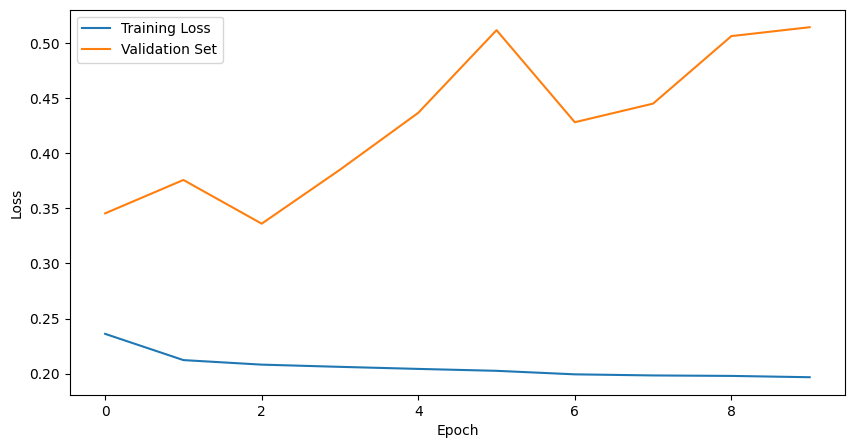

In [14]:
params_reg = {
    "model_class": "RegressorV3",
    "model_params": {
        "hidden_dim": 64,
        "num_output": 1,
        "humidity_dim": 8,
        "group_embed_dim": 16,
        "bias": True,
        "dropout_rate": 0.3,
    },
    "training_params": {
        "n_epochs": 10,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 256,
        "patience": 2,
        "factor": 0.5,
        "min_lr": 1e-6,
        "loss": "WeightedRMSELoss",
    },
}

try:
    ramtnet_reg = run_nn_experiment(
        x_train,
        y_train_reg,
        x_test,
        [(x_val, y_val_reg)],
        params=params_reg,
        uda=False,
        verbose=True,
        plot_losses=True,
        labels=None,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

## Predict

In [20]:
write_submissions(
    best_rf_model,
    test_x_path,
    "submissions_best_rf.csv",
    use_embed=False,
    **test_params_pipeline,
)

Using 13 features


In [ ]:
submit_nn(
    "ramtnet_base.pth",
    "RAMTNet",
    params_ramt["model_params"],
    params_pipeline_dl,
    test_x_path,
    "submissions_ramtnet_base.csv",
)